<a href="https://colab.research.google.com/github/kerryback/2022-BUSI520/blob/main/ML1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# models used in this notebook
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LogisticRegression

# to select best hyperparameters
from sklearn.model_selection import GridSearchCV

# preprocessing steps
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

# to combine preprocessing and fitting
from sklearn.pipeline import make_pipeline

# useful tools for classification problems
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay


### A small data set

In [ ]:
data = pd.read_csv("https://www.dropbox.com/s/012c6y4gxsxss6y/ghz.csv?dl=1", parse_dates=["date"])
data.permno = data.permno.astype(int)
data['date'] = data.date.dt.to_period('M')
data = data.sort_values(by=['permno', 'date']).reset_index(drop=True)
data.ret *= 100

### OLS with statsmodels

In [ ]:
model = smf.ols("ret ~ acc + agr", data=data)
result = model.fit()
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     11.78
Date:                Mon, 12 Sep 2022   Prob (F-statistic):           7.63e-06
Time:                        09:31:36   Log-Likelihood:            -1.1078e+06
No. Observations:              282598   AIC:                         2.216e+06
Df Residuals:                  282595   BIC:                         2.216e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3470      0.030     45.338      0.000       1.289       1.405
acc            0.1735      0.282      0.616      0.538      -0.378       0.725
agr           -0.3454      0.071     -4.836      0.000      -0.485      -0.205
==============================================================================
Omnibus:                   481798.941   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      16139038607.161
Skew:                          10.459   Prob(JB):                         0.00
Kurtosis:                    1173.552   Cond. No.                         12.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### OLS with scikit-learn

In [ ]:
model = LinearRegression()
X = data[['acc', 'agr']]
y = data['ret']

model.fit(X,y)

print("intercept =", model.intercept_, ", OLS betas =", model.coef_)

intercept = 1.3469625469981983 , OLS betas = [ 0.17345459 -0.34536579]


### Predicting with scikit-learn

In [ ]:
newx = pd.DataFrame({"acc": [0.1], "agr": [0.2]})
model.predict(newx)

array([1.29523485])

### Train and test

In ML, models are evaluated by how well they predict out of sample.  Split the data into train and test sets.  Fit the model on the training set.  Evaluate on the test set.  The standard metric for evaluating performance is the out-of-sample $R^2$.

The out-of-sample $R^2$ is 1 - (sum of squared errors) / (sum of squared deviations from mean).  The model can be worse than predicting the mean (the mean is calculated from ytest and the model doesn't use ytest), so the out-of-sample $R^2$ can be negative.

It is common to randomly split into training and test sets.  But, asset return data has a time element, and we usually take the test set to be after the training set.  Here is an example.

In the model.fit line, regression coefficients are computed on the training data.  

In the model.score line, the same regression coefficients are applied to the X variables in the test data to get predictions.  These predictions are compared to the actual y data in the test data set, andhe $R^2$ of the predictions is computed.

In [ ]:
train = data[data.date<"2020"].copy()
test = data[data.date>="2020"].copy()

Xtrain = train[['acc', 'agr']]
Xtest = test[['acc', 'agr']]

ytrain = train.ret 
ytest = test.ret

model.fit(Xtrain, ytrain)
score = model.score(Xtest, ytest)
print(f"OLS out-of-sample R2 is {score:.4f}")

OLS out-of-sample R2 is -0.0027


### Lasso

OLS minimizes the mean squared error.  Lasso is an example of "penalized linear regression."  It chooses coefficients to minimize

$$\frac{1}{2}\text{MSE} + \text{penalty} \times \sum_{i=1}^n |\beta_i|$$

The penalty is a parameter you input.  It is called "alpha" (not the regression intercept).

The penalty is an example of what is called a hyperparameter.  It is not fit from the data.  Instead, it is an input.  We will discuss how to choose it optimally.

The larger the penalty, the smaller the estimated betas will be.  For large alpha, the estimated betas will be zeros.

Lasso is a way to do "automatic feature selection."  Features are variables used to predict.  Dropping variables with zero lasso betas is a reasonable thing to do in some settings.

In [ ]:
for alpha in (0.0001, 0.001, 0.01, 0.1, 1):
    model = Lasso(alpha=alpha)
    model.fit(X,y)
    print("alpha = ", alpha, ", Lasso betas = ", model.coef_)

alpha =  0.0001 , Lasso betas =  [ 0.15824011 -0.3442439 ]
alpha =  0.001 , Lasso betas =  [ 0.02130976 -0.33414689]
alpha =  0.01 , Lasso betas =  [ 0.         -0.24684358]
alpha =  0.1 , Lasso betas =  [ 0. -0.]
alpha =  1 , Lasso betas =  [ 0. -0.]


### Train and test with lasso

In [ ]:
alpha = 0.01
model = Lasso(alpha=alpha)
model.fit(Xtrain, ytrain)
score = model.score(Xtest, ytest)
print(f"Lasso out-of-sample R2 with alpha={alpha:.2f} is {score:.4f}")

Lasso out-of-sample R2 with alpha=0.01 is -0.0027


### Ridge regression

In ridge regression, the coefficients are chosen to minimize
$$\text{SSE} + \text{penalty} \times \sum_{i=1}^n \beta_i^2$$
Again, the penalty is called "alpha."

In [ ]:
for alpha in (10, 100, 1000, 10000):
    model = Ridge(alpha=alpha)
    model.fit(X,y)
    print("alpha = ", alpha, ", Ridge betas = ", model.coef_)

alpha =  10 , Ridge betas =  [ 0.17251647 -0.34523807]
alpha =  100 , Ridge betas =  [ 0.16450115 -0.3440968 ]
alpha =  1000 , Ridge betas =  [ 0.11197401 -0.33332903]
alpha =  10000 , Ridge betas =  [ 0.02521629 -0.25615389]


### Train and test with ridge regression

In [ ]:
alpha=10000
model = Ridge(alpha=alpha)
model.fit(Xtrain, ytrain)
score = model.score(Xtest, ytest)
print(f"Ridge out-of-sample R2 with alpha={alpha:,.0f} is {score:.4f}")


Ridge out-of-sample R2 with alpha=10,000 is -0.0026


### Elastic net

An elastic net combines the lasso and ridge penalties.  It chooses coefficients to minimize
$$\frac{1}{2} \text{MSE} + \text{alpha} \times \text{l1\_ratio} \times \sum_{i=1}^n |\beta_i| + 
\text{alpha} \times (1 - \text{l1\_ratio}) \sum_{i=1}^n \beta_i^2$$

The sum of absolute values penalty is called an $\ell^1$ penalty.  The sum of squares is called an $\ell^2$ penalty.



In [ ]:
alpha = 1
l1_ratio = 0.5
model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
model.fit(Xtrain, ytrain)
score = model.score(Xtest, ytest)
print(f"Elastic net out-of-sample R2 with alpha={alpha:.3f} and l1_ratio={l1_ratio:.3f} is {score:.4f}")

Elastic net out-of-sample R2 with alpha=1.000 and l1_ratio=0.500 is -0.0025


### An aside on creating grids

linspace(a,b) creates a grid [x0=1, x1, ..., xn=b] with points equally spaced.

The default base for logspace is 10.  logspace(a,b) creates a grid [x0=a, x1, ..., xn=b] with points equally spaced and returns [10^x0, 10^x1, ..., 10^xn].  So, it samples small numbers more closely.

In [ ]:
grid1 = np.linspace(0.01, 100, 5)
grid2 = np.logspace(-2, 2, 5)

np.set_printoptions(suppress=True)
print(grid1)
print(grid2)

[  0.01    25.0075  50.005   75.0025 100.    ]
[  0.01   0.1    1.    10.   100.  ]


### Train, validate, and test

To choose hyperparameters like alpha and the l1_ratio in the elastic net, we don't want to optimize the score on the test set.  The maximum score is a biased estimate of what the model will achieve on new data.  So, we split our data into three sets and do the following:

* train on the train set
* calculate scores on the validation set
* choose the hyperparameters with the best score on the validation set and retrain on train+validation sets
* test on the test set

Usually, the train, validation, and test sets are chosen randomly, but it is customary in asset pricing to train on old data, validate on newer data, and test on the newest data.

In [ ]:
train2 = data[data.date<"2015"]
validate = data[(data.date>="2015") & (data.date<"2020")]

Xtrain2 = train2[['acc', 'agr']]
Xvalidate = validate[['acc', 'agr']]

ytrain2 = train2.ret 
yvalidate = validate.ret 

alphas = np.logspace(-4, 2, 11)   
l1_ratios = np.linspace(0.001, 0.999, 11)

dct = {}
for alpha in alphas:
    for l1_ratio in l1_ratios:
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
        model.fit(Xtrain2, ytrain2)
        score = model.score(Xvalidate, yvalidate)
        dct[(alpha, l1_ratio)] = score
        
best_params = max(dct, key=dct.get)
print(f"best alpha is {best_params[0]:.4f}")
print(f"best l1_ratio is {best_params[1]:.4f}")


best alpha is 0.0016
best l1_ratio is 0.9990


Having gotten some idea of what the best parameters are, we can search again within a narrower range.

In [ ]:
alphas = np.logspace(-3, -2, 11)
l1_ratios = np.linspace(l1_ratios[-2], l1_ratios[-1], 11)
for alpha in alphas:
    for l1_ratio in l1_ratios:
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
        model.fit(Xtrain2, ytrain2)
        score = model.score(Xvalidate, yvalidate)
        dct[(alpha, l1_ratio)] = score

best_params = max(dct, key=dct.get)
print(f"best alpha is {best_params[0]:.4f}")
print(f"best l1_ratio is {best_params[1]:.4f}")

best alpha is 0.0020
best l1_ratio is 0.9990


Re-fit on full training set (train = train2+validate) and test on test set.

In [ ]:
alpha = best_params[0]
l1_ratio = best_params[1]
model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
model.fit(Xtrain, ytrain)
score = model.score(Xtest, ytest)
print(f"Elastic net out-of-sample R2 with alpha={alpha:.3f} and l1_ratio = {l1_ratio:.4f} is {score:.4f}")

Elastic net out-of-sample R2 with alpha=0.002 and l1_ratio = 0.9990 is -0.0027


### Aside on storing calculations from loops

We stored the elastic net calculations in a dictionary.  Here are some other options.

In [ ]:
# make the examples simpler

alphas = alphas[:3]
l1_ratios = l1_ratios[:3] 

# # store in a list

lst = []
for alpha in alphas:
    for l1_ratio in l1_ratios:
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
        model.fit(Xtrain2, ytrain2)
        score = model.score(Xvalidate, yvalidate)
        lst.append(score)

# store in a data frame

df = pd.DataFrame(dtype=float, columns=['alpha', 'l1_ratio', 'score'])
for alpha in alphas:
    for l1_ratio in l1_ratios:
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
        model.fit(Xtrain2, ytrain2)
        score = model.score(Xvalidate, yvalidate)
        df.loc[df.shape[0]+1] = [alpha, l1_ratio, score]

# store in a series

indx = pd.MultiIndex.from_tuples(zip(alphas, l1_ratios))
ser = pd.Series(dtype=float, index=indx)
ser.index.names = ['alpha', 'l1_ratio']
for alpha in alphas:
    for l1_ratio in l1_ratios:
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
        model.fit(Xtrain2, ytrain2)
        score = model.score(Xvalidate, yvalidate)
        ser[(alpha, l1_ratio)] = score


# lst
# df
# ser
"""
ser.name = "score"
ser = ser.reset_index()
ser
"""

'\nser.name = "score"\nser = ser.reset_index()\nser\n'

### k-fold cross validation

Instead of one training and one validation set, k-fold cross validation uses k training and validation sets.  

First, split the data into train and test (no validation).  

Then run k-fold cross validation on the training set.  The default for GridSearchCV is k=5.  With k=5, the training set is split into five pieces randomly.  1 of the 5 is chosen to be the validation set and the other 4 are lumped together to be a training set.  For each set of hyperparameters, the model is trained on the training set and tested on the validation set and the scores are saved.  Then a different 1 of the 5 is chosen to be the validation set and the process is repeated.  After all 5 have been used as validation sets, we have 5 scores for each set of hyperparameters.  Average them.  The hyperparameters with the highest average are the best parameters.

GridSearchCV has an optional argument "refit" with the default being True.  This means that the model is refit on the full training set (all k folds) using the best set of hyperparameters.  This means that we are ready to test the model on the test set.



In [ ]:
alpha_grid = np.logspace(-3, -1, 3)
l1_ratio_grid = np.linspace(0.001, 0.999, 3)
cv = GridSearchCV(ElasticNet(), param_grid={"alpha": alpha_grid, "l1_ratio": l1_ratio_grid})
cv.fit(Xtrain, ytrain)
score = cv.score(Xtest, ytest)
print("best parameters are", cv.best_params_)
print("out of sample R2 is", score)
print("cross-validation results are")
pd.DataFrame(cv.cv_results_)

best parameters are {'alpha': 0.01, 'l1_ratio': 0.001}
out of sample R2 is -0.0027107038872318245
cross-validation results are


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.027024,0.007122,0.004405,0.001192,0.001,0.001,"{'alpha': 0.001, 'l1_ratio': 0.001}",0.000304,2.683273e-04,0.000198,-0.000193,0.000171,0.000150,0.000178,2
1,0.022071,0.007224,0.002672,0.001794,0.001,0.5,"{'alpha': 0.001, 'l1_ratio': 0.5}",0.000300,2.702071e-04,0.000201,-0.000198,0.000169,0.000148,0.000179,3
2,0.019381,0.002312,0.001406,0.001961,0.001,0.999,"{'alpha': 0.001, 'l1_ratio': 0.999}",0.000296,2.722209e-04,0.000204,-0.000205,0.000167,0.000147,0.000182,4
3,0.018990,0.001999,0.001999,0.002449,0.01,0.001,"{'alpha': 0.01, 'l1_ratio': 0.001}",0.000272,2.687337e-04,0.000207,-0.000168,0.000170,0.000150,0.000164,1
4,0.022987,0.006778,0.001999,0.002449,0.01,0.5,"{'alpha': 0.01, 'l1_ratio': 0.5}",0.000241,2.673045e-04,0.000211,-0.000162,0.000166,0.000145,0.000157,5
5,0.020993,0.001997,0.002994,0.002444,0.01,0.999,"{'alpha': 0.01, 'l1_ratio': 0.999}",0.000211,2.579378e-04,0.000201,-0.000148,0.000166,0.000138,0.000146,6
6,0.020994,0.002009,0.002993,0.002444,0.1,0.001,"{'alpha': 0.1, 'l1_ratio': 0.001}",0.000094,1.898230e-04,0.000130,-0.000064,0.000140,0.000098,0.000087,7
7,0.018227,0.002189,0.005003,0.003169,0.1,0.5,"{'alpha': 0.1, 'l1_ratio': 0.5}",-0.000183,2.746470e-05,-0.000054,-0.000055,0.000002,-0.000052,0.000073,8
8,0.025157,0.012768,0.000994,0.001988,0.1,0.999,"{'alpha': 0.1, 'l1_ratio': 0.999}",-0.000183,-1.029057e-07,-0.000061,-0.000068,-0.000001,-0.000063,0.000067,9


### Outliers and skewness

Any standardizations that we apply on the training set must be applied also on the test set and for any new observations for which we want to predict.  

If we winsorize, for example, we have to store the procedure (which points get mapped where) so we can apply it to new data.

Winsorizing and taking logs are common in academic statistical work, but there are other transformations commonly used in ML.  Quantile transformer maps a variable monotonically into a variable having the desired distribution.

In [ ]:
qt = QuantileTransformer(output_distribution="normal")

# the fit_transform method needs a column vector
agr = data.agr.to_numpy().reshape(-1,1)

data['transformed_agr'] = qt.fit_transform(agr)

# see what we did

# data.sort_values(by="date").head()

"""
sns.kdeplot(data.agr, label="agr")
sns.kdeplot(data.transformed_agr, label="transformed agr")
plt.legend()
"""

'\nsns.kdeplot(data.agr, label="agr")\nsns.kdeplot(data.transformed_agr, label="transformed agr")\nplt.legend()\n'

### Scaling

Penalized regression penalizes all coefficients the same, so it is important that the input variables be on the same scale.  StandardScaler subtracts the mean and divides by the std dev, so the transformed variable has zero mean and unit variance.

In [ ]:
transformed_agr = data.transformed_agr.to_numpy().reshape(-1,1)
scaler = StandardScaler()
data['transformed2_agr'] = scaler.fit_transform(transformed_agr)

# sns.kdeplot(data.transformed2_agr)


### Pipelines

We don't want to apply QuantileTransformer and StandardScaler directly to test data.  That would create new transformations, based on the properties of the test data.  How would we create those transformations for new observations?

Instead, we want to remember the transformations used on the training data and apply the same transformations to the test data (and to any new observations that arise).  For example, StandardScaler subtracts a number (the mean) and divides by a number (the std dev).  We want to subtract the same number and divide by the same number on the test data.

Pipelines let us transform and fit in one step.  Then, when we score the model on the test data, the same transformation is applied to the test data.

In [ ]:
alpha = 0.001
l1_ratio = 0.5
model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)

qt = QuantileTransformer(output_distribution="normal")
scale = StandardScaler()
pipe = make_pipeline(qt, scale, model)

pipe.fit(Xtrain, ytrain)
score = pipe.score(Xtest, ytest)
print(f"With standardization, elastic net out-of-sample R2 with alpha={alpha:.3f} and l1_ratio = {l1_ratio:.4f} is {score:.4f}")


With standardization, elastic net out-of-sample R2 with alpha=0.001 and l1_ratio = 0.5000 is -0.0028


### Adding squares, products, etc.

PolynomialFeatures expands the number of right-hand side variables.  With degree=2, it adds all squares and products.  With degree=3, it also adds all cubes and $x_1 \times x_2 \times x_3$ (including $x_1 \times x_2^2$, etc.)

In [ ]:
poly = PolynomialFeatures(degree=3)

pipe = make_pipeline(qt, scale, poly, model)

pipe.fit(Xtrain, ytrain)
score = pipe.score(Xtest, ytest)
print(f"With standardization and poly features, elastic net out-of-sample R2 with alpha={alpha:.3f} and l1_ratio = {l1_ratio:.4f} is {score:.4f}")

With standardization and poly features, elastic net out-of-sample R2 with alpha=0.001 and l1_ratio = 0.5000 is -0.0027


### Principal components

The principal components of a set of variables are linear combinations of the variables.  The linear coefficients are the eigenvectors corresponding to the largest eigenvalues.  These linear combinations have the highest variance, so they are regarded as likely to be the most informative.

Principal components is one type of "dimensionality reduction."

In [ ]:
pca = PCA(n_components=4)

pipe = make_pipeline(qt, scale, poly, pca, model)

pipe.fit(Xtrain, ytrain)
score = pipe.score(Xtest, ytest)
print(f"With standardization, poly features, and PCA, elastic net out-of-sample R2 with alpha={alpha:.3f} and l1_ratio = {l1_ratio:.4f} is {score:.4f}")

With standardization, poly features, and PCA, elastic net out-of-sample R2 with alpha=0.001 and l1_ratio = 0.5000 is -0.0024


### Cross validation on a pipeline

We can pass a pipeline to GridSearchCV and we can use it to evaluate hyperparameters of the transformations as well as hyperparameters of the model.

In the dictionary specifying the parameter grids, the keys must be the transform or model name in lower case followed by a double underscore followed by the parameter name.  

In [ ]:
model = ElasticNet()
poly = PolynomialFeatures()
pca = PCA()
pipe = make_pipeline(qt, scale, poly, pca, model)

alpha_grid = np.logspace(-3, -1, 3)
l1_ratio_grid = np.linspace(0.1, 0.9, 3)
poly_grid = (2, 3)
pca_grid = (2, 4)
param_grid = {
    "elasticnet__alpha": alpha_grid,
    "elasticnet__l1_ratio": l1_ratio_grid,
    "polynomialfeatures__degree": poly_grid,
    "pca__n_components": pca_grid
}

cv = GridSearchCV(pipe, param_grid=param_grid)
cv.fit(Xtrain, ytrain)
score = cv.score(Xtest, ytest)

print("best parameters are", cv.best_params_)
print("out of sample R2 is", score)

best parameters are {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.1, 'pca__n_components': 4, 'polynomialfeatures__degree': 2}
out of sample R2 is -0.0027194797517058333


### Target variable

If we want to pick stocks, rather than time the market, then we should be trying to predict relative performance.  One possibility is to use the return in excess of the cross-sectional mean each month as the target variable.

In [ ]:
train.loc[:, 'xret'] = train.groupby('date').ret.apply(lambda x: x - x.mean())
test.loc[:, 'xret'] = test.groupby('date').ret.apply(lambda x: x - x.mean())

ytrain = train.xret
ytest = test.xret

cv = GridSearchCV(pipe, param_grid=param_grid)
cv.fit(Xtrain, ytrain)
score = cv.score(Xtest, ytest)

print("best parameters are", cv.best_params_)
print("out of sample R2 is", score)


best parameters are {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.5, 'pca__n_components': 2, 'polynomialfeatures__degree': 3}
out of sample R2 is 9.241002070758952e-05


### Sensitivity to outliers

Minimizing the sum of *squared* errors causes outlier values of the target variable to have a large influence on the coefficient estimates.  Minimizing the sum of *absolute* errors is often a better choice.  

Another possibility is to transform the target variable.  For example, if we want to predict relative performance, we could use the ranks of returns rather than the returns as the target.  Because the number of stocks may vary over time, we should normalize the ranks, for example to lie between 0 and 1.  This can be done using pandas percentile rank method.

In [ ]:
train['pct'] = train.groupby('date').ret.rank(pct=True)
test['pct'] = test.groupby('date').ret.rank(pct=True)

ytrain = train.pct
ytest = test.pct 

cv = GridSearchCV(pipe, param_grid=param_grid)
cv.fit(Xtrain, ytrain)
score = cv.score(Xtest, ytest)

print("best parameters are", cv.best_params_)
print("out of sample R2 is", score)

best parameters are {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.1, 'pca__n_components': 4, 'polynomialfeatures__degree': 2}
out of sample R2 is 0.0011142641981700674


## Classification

Many ML problems are classification problems.  Logistic regression is one classification model.  The default imposes an $\ell^2$ penalty.  We can specify penalty="l1", penalty="l2", penalty="elasticnet", or penalty="none."  If penalty="elasticnet", specify l1_ratio and solver="saga."  The size of the penalty is inverse to the parameter C.

We can put logistic regression in a pipeline with preprocessing transformations as in the previous example, and we can run the pipeline through GridSearchCV as in the previous example.

The score for logistic regression is the fraction of correct predictions.  

In [ ]:
train['category'] = train.groupby('date').ret.apply(lambda x: 1*(x>x.median()))
test['category'] = test.groupby('date').ret.apply(lambda x: 1*(x>x.median()))

ytrain = train.category
ytest = test.category

model = LogisticRegression(penalty="l2", C=0.001)
model.fit(Xtrain, ytrain)
score = model.score(Xtest, ytest)
print("fraction of correct predictions on test data is", score)

fraction of correct predictions on test data is 0.4955625


### Predictions and probabilities

In [ ]:
predictions = pd.Series(model.predict(Xtest))
probabilities = pd.DataFrame(model.predict_proba(Xtest), columns=[0,1])
print(predictions.head())
print(probabilities.head())

0    1
1    1
2    1
3    1
4    1
dtype: int32
          0         1
0  0.499163  0.500837
1  0.499163  0.500837
2  0.499163  0.500837
3  0.499802  0.500198
4  0.499802  0.500198


### Confusion matrix

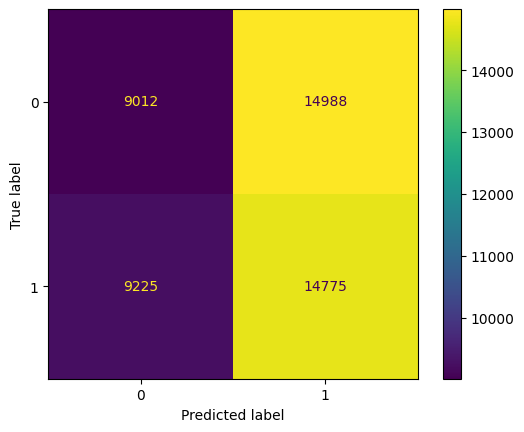

In [ ]:
ConfusionMatrixDisplay.from_estimator(estimator=model, X=Xtest, y=ytest)

### ROC curve

ROC = Receiver Operating Characteristics (not sure why).  In binary classification, we can vary the threshold to change the frequency of "positive" predictions (in our case, positive = return above median).  Hopefully, we can increase the number of true positives without increasing the number of false positives too much.  This corresponds to an ROC curve above the 45 degree line.  In our case, our predictions are basically random, which manifests as ROC curve = 45 degree line.

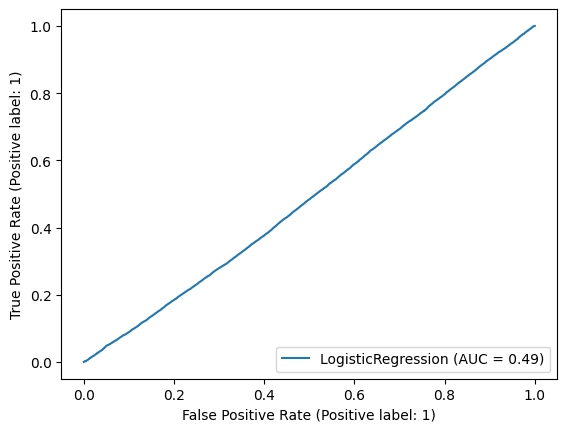

In [ ]:
RocCurveDisplay.from_estimator(estimator=model, X=Xtest, y=ytest)

### Multi-class classification

In [ ]:
train['category'] = train.groupby('date').ret.apply(lambda x: pd.qcut(x, 3, labels=range(1,4)))
test['category'] = test.groupby('date').ret.apply(lambda x: pd.qcut(x, 3, labels=range(1,4)))

ytrain = train.category
ytest = test.category

model = LogisticRegression(penalty="l2", C=0.001)
model.fit(Xtrain, ytrain)
score = model.score(Xtest, ytest)
print("fraction of correct predictions on test data is", score)

fraction of correct predictions on test data is 0.35804166666666665


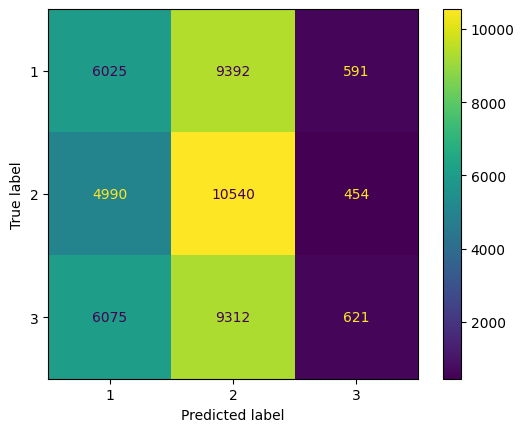

In [ ]:
ConfusionMatrixDisplay.from_estimator(estimator=model, X=Xtest, y=ytest)

In [ ]:
ytrain.sum() / len(ytrain)

TypeError: 'Categorical' with dtype category does not support reduction 'sum'